Importing necessary libraries

In [1]:
from numpy import linalg as lg
from IPython.display import display, Math, Latex

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **Polynomial regression**

This colab implements polynomial regression from scratch with basic python libraties like `numpy`. Recall that polynomial regression is linear regression wtih  an additional step of polynomial transformation.
    
                            Features --> polynomial transformation --> Linear regression --> Label
we will use `LinReg` class that implements linear regression model.
We will implement:
* Polynomial transformation function.

* Function for generation of training data with non-linear relationship between features and labels. We generate examples with single features $x_1$ and label $y$.
* Also a function for visualization of training data and model fitting.

We use polynomial transformations of different degress for modelling relationship between input features and labels. Each degree results in a new polynomial model. 

Thus, we have multiple polynomial models from which we need to select the best performing model. Implementation of the model selection scheme is performed at the end of this notebook.

Combining the implementation of different components of Linear Regression that we implemented so far into a single `LinearRegression` class.

In [2]:
class LinReg(object):
    '''
    Linear regression model 
    -----------------------
    y = X@w 
    X : A feature matrix 
    w : weight vector
    y : label vector

    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100_000

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Prediction of output label for a given input.

        Args: 
        X: Feature matrix for given inputs.
        
        Returns:
        y: Output label vector as predicted by the given model

        '''
        y = X@self.w
        return y

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        ''' 
        Calculates loss for a model based on known labels:

        Args: 
        X: Feature matrix for given inputs.
        Returns:
        y: Output label vector as predicted by the given model
        
        Returns:
        y: Output label vector as predicted by the given model

        '''
        e = self.predict(X) - y

        return (1/2) * (np.transpose(e)@e)

    def rmse(self, X: np.ndarray, y: np.ndarray) -> float:

        '''
        Calculates root mean squared error of prediction w.r.t. actual label:

        Args: 
        X: Feature matrix for given inputs.
        Returns:
        y: Output label vector as predicted by the given model
        
        Returns:
        rmse 

        '''
        return np.sqrt(2/X.shape[0] * self.loss(X, y))

    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:

        '''' 
        Estimates parameters of the linear regression model with normal equation.

        Args:
        X: Feature matrix for given inputs 
        y: output label vector as predicted by the given model

        Returns:
        weight vector 

        '''
        self.w = np.linalg.pinv(X)@y

    def calculate_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        ''' 
        calculates gradients of loss function w.r.t weight vector on training set.

        Returns:
        A vector of gradient .
        '''

        return np.transpose(X)@(self.predict(X)-y)

    def update_weight(self, grad: np.ndarray, lr: float) -> np.ndarray:
        return(self.w - lr*grad)

    def learning_schedule(self, t):
        return self.t0/(t+self.t1)

    def gd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, lr: float) -> np.ndarray:
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        for i in np.arange(0, num_epochs):
            djdw = self.calculate_gradient(X, y)
            self.w_all.append(w)
            self.err_all.append(self.loss(X, y))
            self.w = self.update_weights(djdw, lr)
        return self.w


##### **Polynomial transformation**

Steps for generating polynomial transformation of degree *M*.
1. Generate combination of input features of lengths $= 0,1,\ldots, \textit M.$
2. Perform multiplication operation between features to obtain the new features.


For example:
* For a single feature $x_1$ , $ \phi_m = [1,x_1^1,x_1^2, \ldots , x_1^m]$

  * Generate combinations of : $\{1,x_1,(x_1,x_1), (x_1,x_1,x_1),\ldots, (x_1,x_1), \ldots, (m times)\}$

    * 0-th degree: 1

    * 1st degree: $x_1$

    * 2nd degree: $x_1,x_1$

    * 3rd degree: $x_1,x_1,x_1$

    * mth degree:$(x_1,x_1,x_1,\ldots ,m \ times)$

  * Taking the product of elements in combination:

In [3]:
import itertools 
import functools 

def get_combinations(X, degree):
    return itertools.combinations_with_replacement(X,degree)

def compute_new_feature(items):
    return functools.reduce(lambda x ,y : x*y , items)

In [4]:
char_lst = []
for i in range(0, 4):
    a = (get_combinations(['a', 'b'], i))

    #print((tuple(a)))

for tuple in a:
    temp = ''
    for char in tuple:
        temp += char
    char_lst.append(temp)

print(len(char_lst))

4


In [5]:
len({item: compute_new_feature(item) for item in get_combinations([1,2,3,4,5],4)})

70

In [6]:
x = np.array([1, 2, 3, 4, 5])

print(x.ndim)
print(x)

if x.ndim == 1:
    x = x[:, None]

print(x)

1
[1 2 3 4 5]
[[1]
 [2]
 [3]
 [4]
 [5]]


In [7]:
features = np.array([np.ones(4)])
features = features[:, None]
features

array([[[1., 1., 1., 1.]]])

In [8]:
def polynomial_transform(x,degree):
    if x.ndim ==1:
        x=x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))]
    for degree in range(1, degree+1):
        for items in itertools.combinations_with_replacement(x_t ,degree):
            features.append(functools.reduce(lambda x ,y : x*y , items)) 
    return np.asarray(features).transpose() 

polynomial_transform(np.array([[1,8],[5,2],[2,0]]),2)

array([[ 1.,  1.,  8.,  1.,  8., 64.],
       [ 1.,  5.,  2., 25., 10.,  4.],
       [ 1.,  2.,  0.,  4.,  0.,  0.]])

**Creating a non-linear training dataset**

In [9]:
def create_nonlinear_training_set(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def nonlin(x):
    return np.sin(2*np.pi*x)

**Visualization of training set**

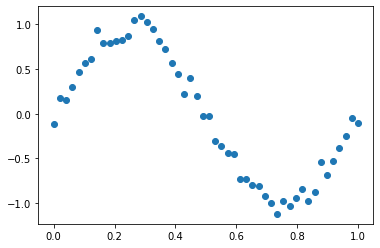

In [10]:
x, y = create_nonlinear_training_set(nonlin, 50, 0.1)
plt.scatter(x, y)
plt.show()

**Combining different components**

In [11]:
def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))]
    for degree in range(1, degree+1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x*y, items))
    return np.asarray(features).transpose()

def coef(X, y):
    return np.linalg.pinv(X)@y

def model_error(X, y, degree):
    X_transformed = polynomial_transform(X, degree)
    w = coef(X_transformed, y)
    e = X_transformed@w - y
    return np.sqrt(1/X_transformed.shape[0] * e.T@e)
